# 0. Importing Modules

In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import distributions
import datetime
import pandas as pd
import pandas_datareader.data as pdr
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from pmdarima.model_selection import RollingForecastCV, cross_val_predict
from options_chains import OptionsChain
import py_vollib.black_scholes as black_scholes_merton
import py_vollib_vectorized
from models import ARIMAForecastModel
from options_chains import OptionsChain

/Users/tayo4pf/Library/CloudStorage/OneDrive-UniversityofCambridge/part-ii-dissertation/arm_venv/lib/python3.10/site-packages/py_lets_be_rational/numba_helper.py:10: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  return jit(*jit_args, **jit_kwargs)(fun)


# 1. Testing ARIMA Model on Returns Datasets

In [17]:
"""
Making training, and testing datasets
Training set is SPY returns from 2014
Testing set is SPY returns in 2019
"""
start = datetime.datetime(2014,1,1)
split_date = datetime.datetime(2019,1,1)
end = datetime.datetime(2020,1,1)
window = 21
spy_returns = distributions.get_returns(["SPY"], "2014-01-01", "2020-01-01")
spy_data = pd.DataFrame({"Log Returns":spy_returns})
spy_data = spy_data.dropna(axis=0, how="all")
spy_data.index = pd.to_datetime(spy_data.index)
spy_data["Realized Volatility"] = distributions.get_realized_volatility(spy_data["Log Returns"],21)

[*********************100%%**********************]  1 of 1 completed


<Axes: xlabel='Date'>

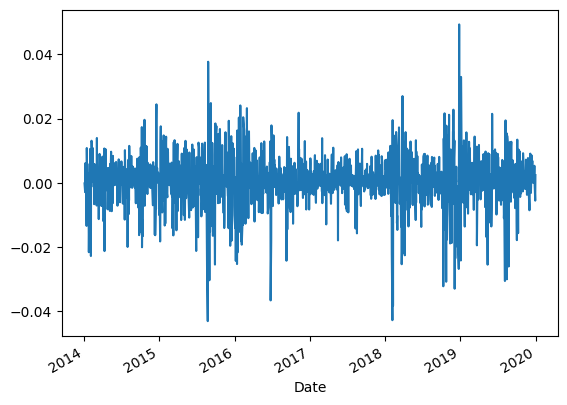

In [16]:
spy_data["Log Returns"].plot()

## 1.1 Non-Seasonal ARIMA Model for SPY

In [18]:
model = pm.arima.ARIMA(order=(3,2,3))
res = model.fit(spy_data["Log Returns"][:split_date]*100)
res.summary()

/Users/tayo4pf/Library/CloudStorage/OneDrive-UniversityofCambridge/part-ii-dissertation/arm_venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/tayo4pf/Library/CloudStorage/OneDrive-UniversityofCambridge/part-ii-dissertation/arm_venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/tayo4pf/Library/CloudStorage/OneDrive-UniversityofCambridge/part-ii-dissertation/arm_venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/tayo

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1257
Model:               SARIMAX(3, 2, 3)   Log Likelihood               -1619.721
Date:                Mon, 29 Jan 2024   AIC                           3255.442
Time:                        14:18:52   BIC                           3296.521
Sample:                             0   HQIC                          3270.882
                               - 1257                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2.876e-05      0.000      0.226      0.821      -0.000       0.000
ar.L1         -0.9601      0.026    -37.356      0.000      -1.011      -0.910
ar.L2         -0.0246      0.041     -0.601      0.548      -0.105       0.056
ar.L3         -0.0293      0.024     -1.202      0.229      -0.077       0.018
ma.L1         -0.8562      0.020    -43.535      0.000      -0.895      -0.818
ma.L2         -0.9920      0.005   -203.331      0.000      -1.002      -0.982
ma.L3          0.8501      0.020     41.769      0.000       0.810       0.890
sigma2         0.7604      0.021     35.396      0.000       0.718       0.803
===================================================================================
Ljung-Box (L1) (Q):                  14.07   Jarque-Bera (JB):              1102.95
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.10   Skew:                             0.40
Prob(H) (two-sided):                  0.31   Kurtosis:                         7.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

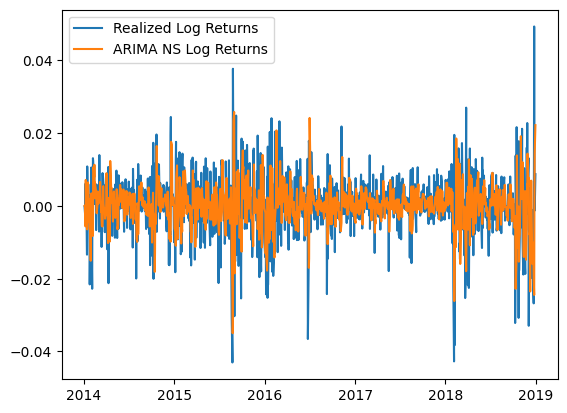

In [5]:
plt.plot(spy_data["Log Returns"][:split_date])
plt.plot(pd.DataFrame({"Log Returns":res.predict_in_sample()}, index = spy_data.index))
plt.legend(["Realized Log Returns", "ARIMA NS Log Returns"])

Text(0.5, 1.0, 'ARIMA Predicted Volatility vs. Realized Volatility from Training Data')

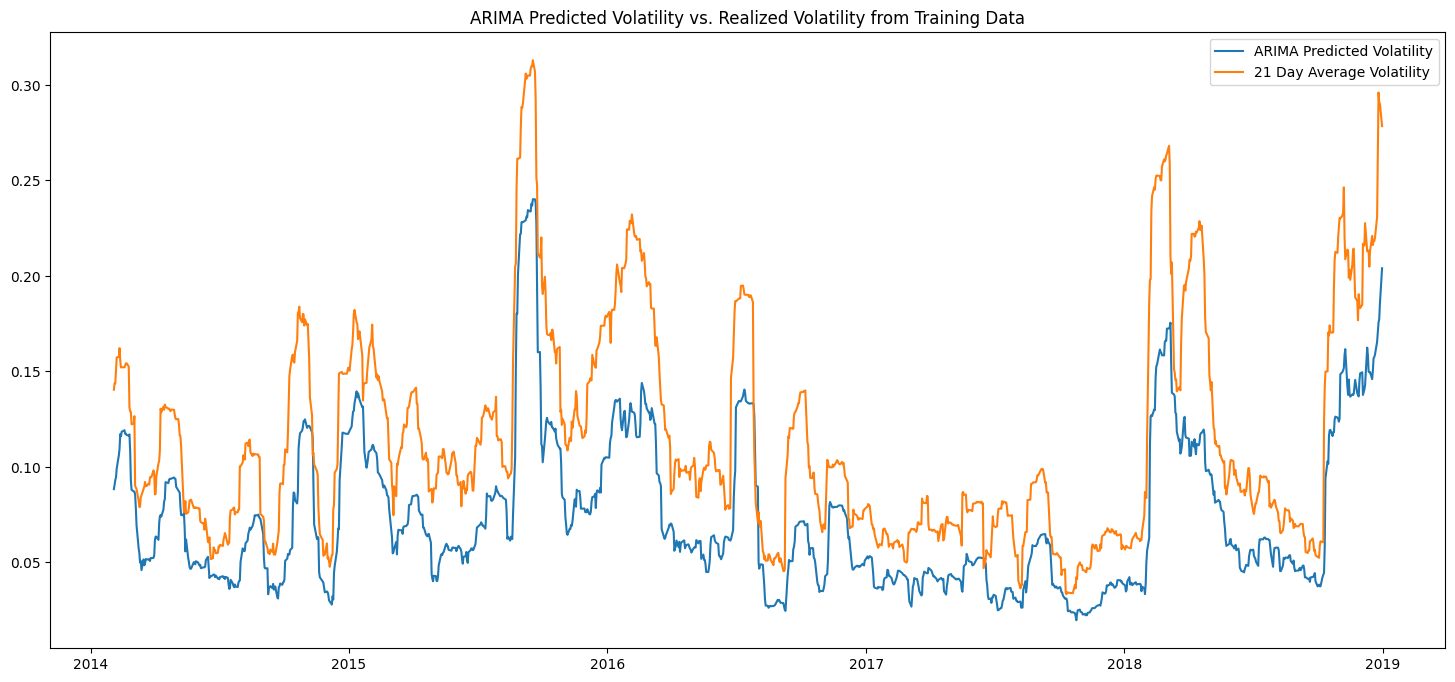

In [6]:
fig = plt.figure(figsize=(18,8))
plt.plot(distributions.get_realized_volatility(pd.DataFrame({"Log Returns":res.predict_in_sample()}), window))
plt.plot(spy_data["Realized Volatility"][:split_date])
plt.legend(["ARIMA Predicted Volatility", "21 Day Average Volatility"])
plt.title("ARIMA Predicted Volatility vs. Realized Volatility from Training Data")

/Users/tayo4pf/Library/CloudStorage/OneDrive-UniversityofCambridge/part-ii-dissertation/arm_venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/tayo4pf/Library/CloudStorage/OneDrive-UniversityofCambridge/part-ii-dissertation/arm_venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


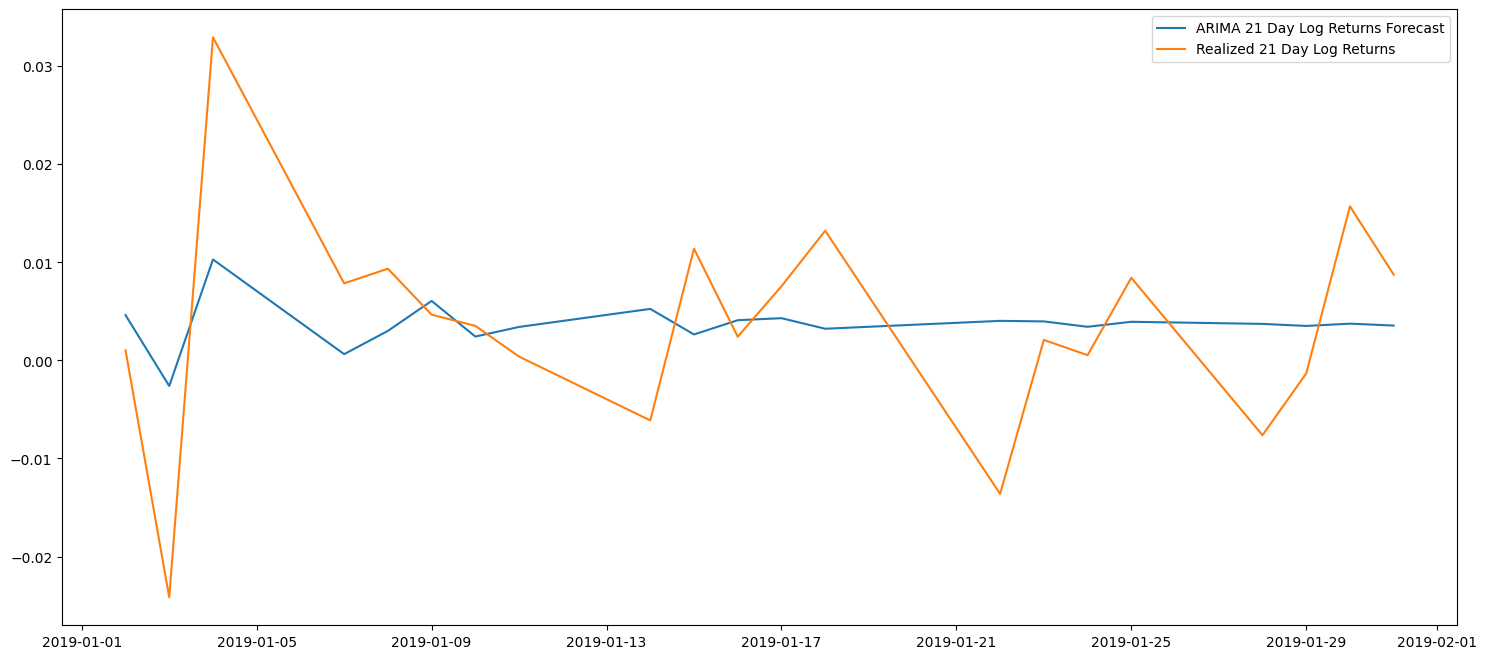

In [7]:
#21 Day Forecast
fig = plt.figure(figsize=(18,8))
forecast_returns_window = pd.DataFrame({"Log Returns": res.predict(n_periods=window)})
forecast_returns_window = forecast_returns_window.set_index(spy_data[split_date:][:window].index)
plt.plot(forecast_returns_window)
plt.plot(spy_data["Log Returns"][split_date:][:window])
plt.legend(["ARIMA 21 Day Log Returns Forecast", "Realized 21 Day Log Returns"])

In [8]:
cv = RollingForecastCV(h=21, step=1, initial=len(spy_data["Log Returns"][:split_date]))
preds = cross_val_predict(pm.ARIMA((3,2,3)), y=spy_data["Log Returns"], cv=cv, return_raw_predictions=True)
arima_ns_forecasted_volatility = np.std(preds, axis=1, ddof=0)*np.sqrt(252)
arima_ns_forecasted_returns = preds[:,-1]
arima_ns_forecast = pd.DataFrame({
    "Forecasted Volatility": arima_ns_forecasted_volatility,
    "Forecasted Log Returns": arima_ns_forecasted_returns
    }, index=spy_data.index)
arima_ns_forecast = arima_ns_forecast.shift(21)

/Users/tayo4pf/Library/CloudStorage/OneDrive-UniversityofCambridge/part-ii-dissertation/arm_venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/tayo4pf/Library/CloudStorage/OneDrive-UniversityofCambridge/part-ii-dissertation/arm_venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/tayo4pf/Library/CloudStorage/OneDrive-UniversityofCambridge/part-ii-dissertation/arm_venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/tayo

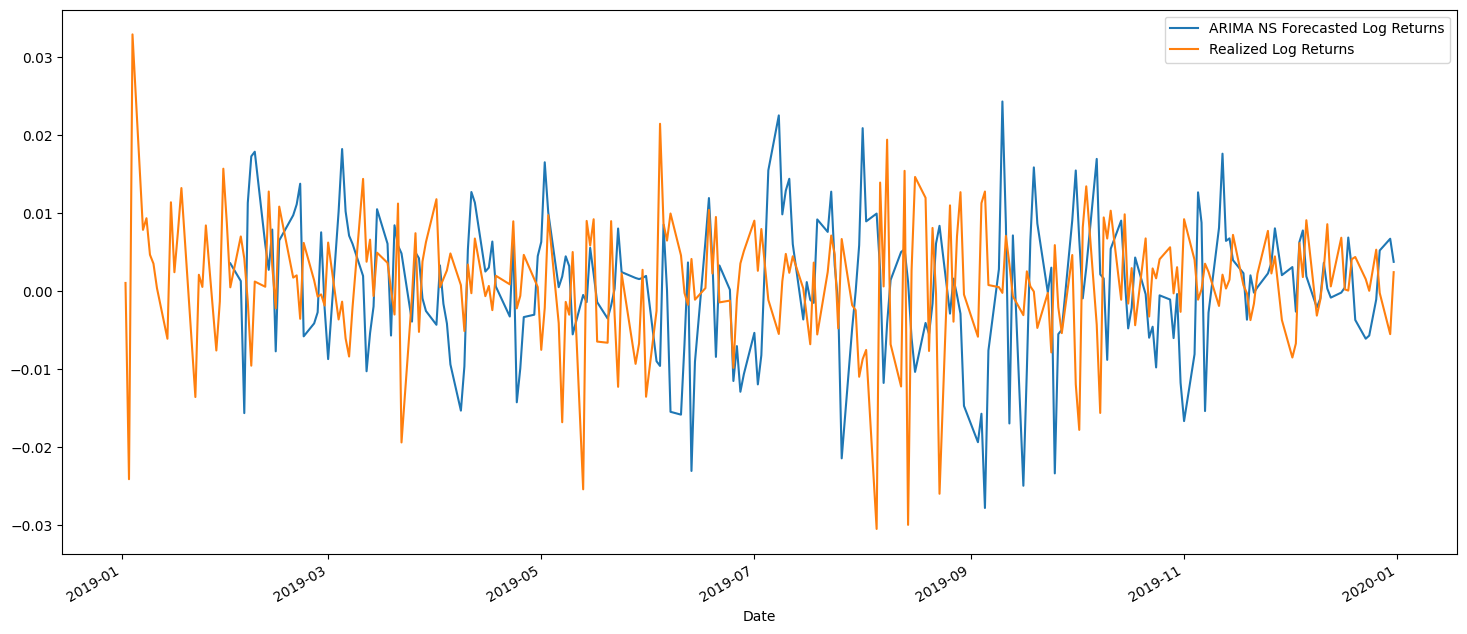

In [9]:
plt.figure(figsize=(18,8))
ax = plt.axes()
arima_ns_forecast["Forecasted Log Returns"].plot(ax=ax)
spy_data["Log Returns"][split_date:].plot(ax=ax)
plt.legend(["ARIMA NS Forecasted Log Returns", "Realized Log Returns"])

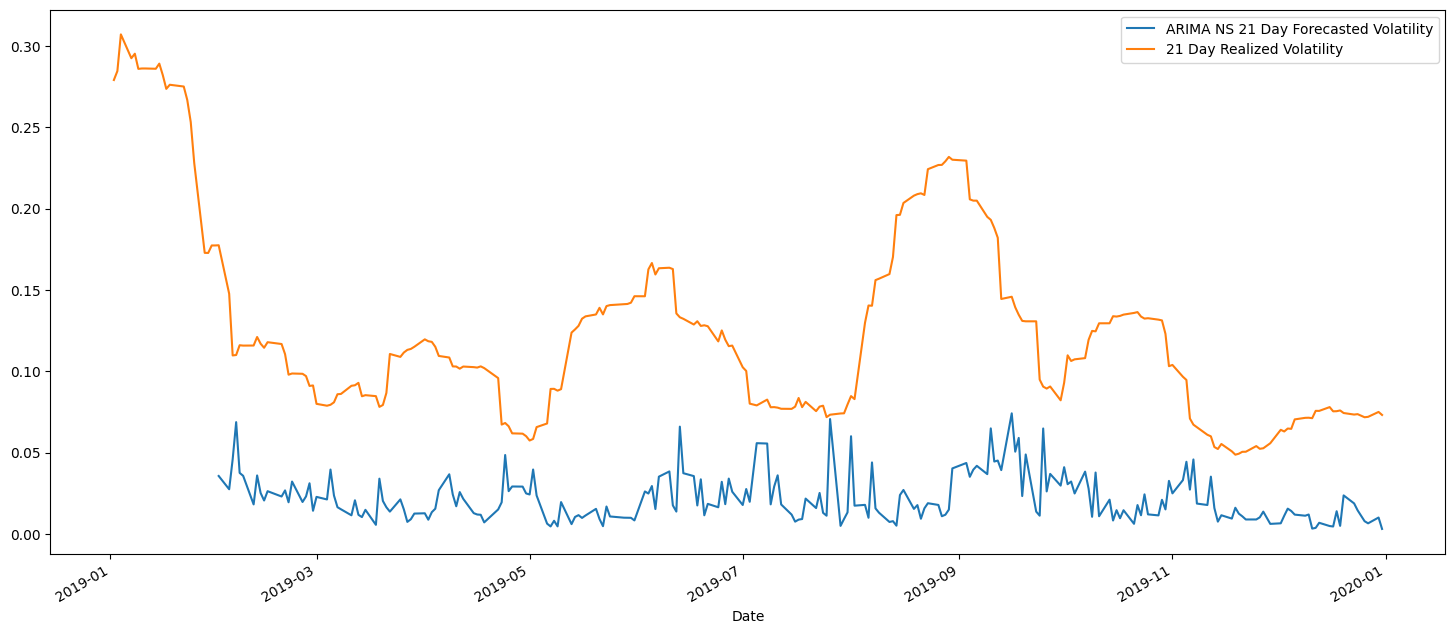

In [10]:
plt.figure(figsize=(18,8))
ax = plt.axes()
arima_ns_forecast["Forecasted Volatility"].plot(ax=ax)
spy_data["Realized Volatility"][split_date:].plot(ax=ax)
plt.legend(["ARIMA NS 21 Day Forecasted Volatility", "21 Day Realized Volatility"])

## 1.2 Seasonal ARIMA Model for SPY

In [11]:
model = pm.arima.ARIMA(order=(2,0,2), seasonal_order=(0,0,0,4))
res = model.fit(spy_data["Log Returns"][:split_date])
res.summary()

/Users/tayo4pf/Library/CloudStorage/OneDrive-UniversityofCambridge/part-ii-dissertation/arm_venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/tayo4pf/Library/CloudStorage/OneDrive-UniversityofCambridge/part-ii-dissertation/arm_venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1257
Model:               SARIMAX(2, 0, 2)   Log Likelihood                4241.522
Date:                Mon, 29 Jan 2024   AIC                          -8471.044
Time:                        13:32:10   BIC                          -8440.226
Sample:                             0   HQIC                         -8459.462
                               - 1257                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0001      0.000      0.988      0.323      -0.000       0.000
ar.L1         -0.0101      0.144     -0.070      0.944      -0.293       0.273
ar.L2          0.6234      0.157      3.974      0.000       0.316       0.931
ma.L1          0.0080      0.138      0.058      0.953      -0.262       0.278
ma.L2         -0.6931      0.147     -4.709      0.000      -0.982      -0.405
sigma2      6.857e-05   1.76e-06     38.951      0.000    6.51e-05     7.2e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               872.15
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               1.15   Skew:                            -0.71
Prob(H) (two-sided):                  0.16   Kurtosis:                         6.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

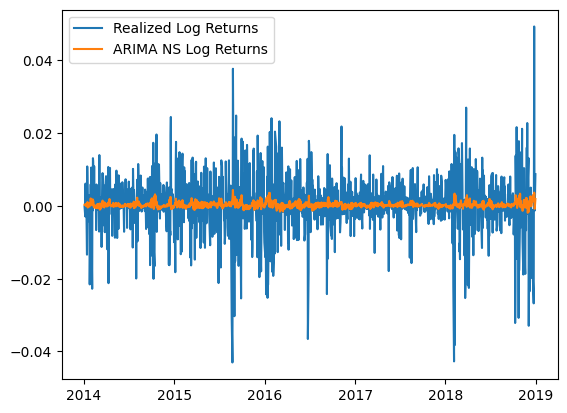

In [12]:
plt.plot(spy_data["Log Returns"][:split_date])
plt.plot(pd.DataFrame({"Log Returns":res.predict_in_sample()}, index = spy_data.index))
plt.legend(["Realized Log Returns", "ARIMA NS Log Returns"])

Text(0.5, 1.0, 'ARIMA Predicted Volatility vs. Realized Volatility from Training Data')

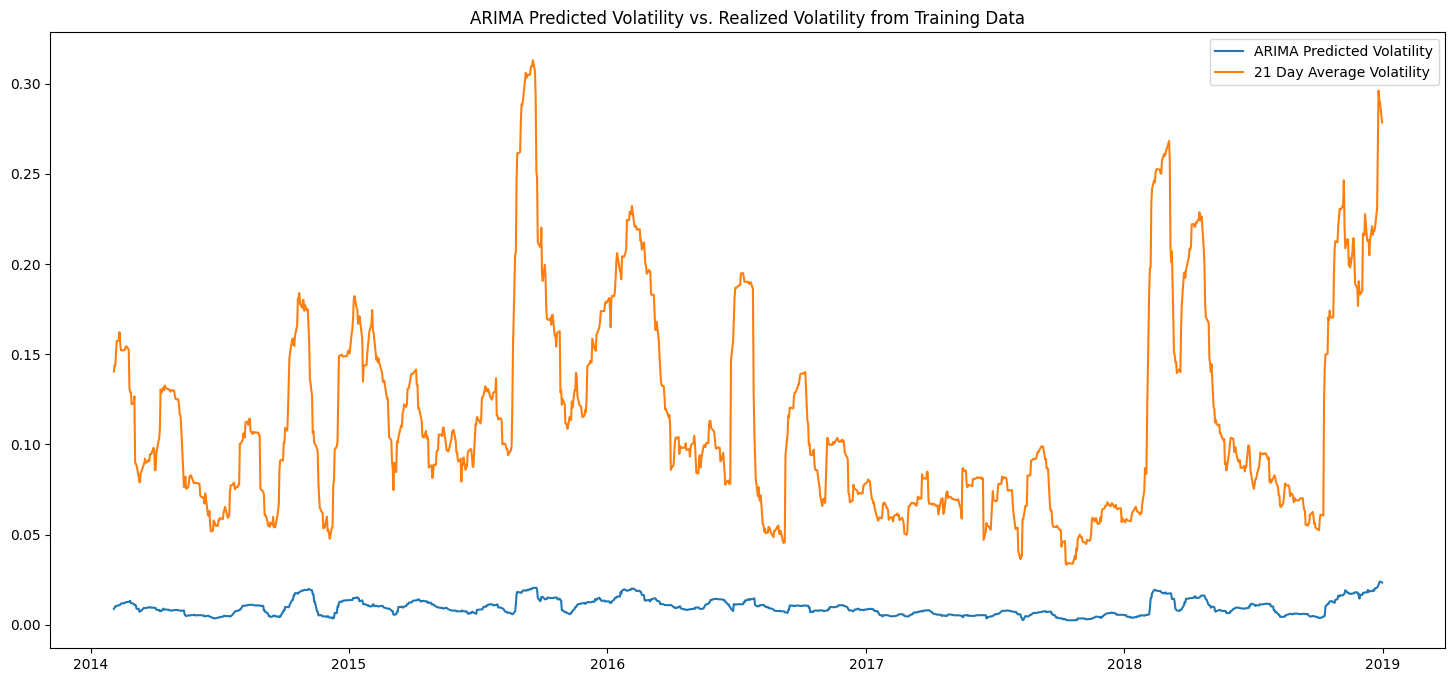

In [13]:
fig = plt.figure(figsize=(18,8))
plt.plot(distributions.get_realized_volatility(pd.DataFrame({"Log Returns":res.predict_in_sample()}), window))
plt.plot(spy_data["Realized Volatility"][:split_date])
plt.legend(["ARIMA Predicted Volatility", "21 Day Average Volatility"])
plt.title("ARIMA Predicted Volatility vs. Realized Volatility from Training Data")

# 2 Contract Simulation

In [25]:
res.arima_res_.simulate(nsimulations=10)/100

Date
2014-01-03     21.830406
2014-01-06     31.481779
2014-01-07     41.162863
2014-01-08     50.817961
2014-01-09     60.476184
2014-01-10     70.150037
2014-01-13     79.796190
2014-01-14     89.463895
2014-01-15     99.109969
2014-01-16    108.785101
Name: y, dtype: float64

In [23]:
options = OptionsChain("SPY", 2019)

In [24]:
iv_dist = options.iv_dist(21, 0.45, 0.55)
ask_dist = options.ask_dist(21, 0.45, 0.55)
bid_dist = options.bid_dist(21, 0.45, 0.55)

# 2.1 ARIMA Non-Seasonal Simulation

# 2.1.0 Creating Simulations

In [2]:
arima_forecaster = ARIMAForecastModel("SPY", "2014-01-01", "2020-01-01", "2019-01-01", 21, (2,0,2))
arima_forecaster.forecaster(21)
simulator = arima_forecaster.simulation(21)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


/Users/tayo4pf/Library/CloudStorage/OneDrive-UniversityofCambridge/part-ii-dissertation/arm_venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/tayo4pf/Library/CloudStorage/OneDrive-UniversityofCambridge/part-ii-dissertation/arm_venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/tayo4pf/Library/CloudStorage/OneDrive-UniversityofCambridge/part-ii-dissertation/arm_venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates

In [3]:
arima_forecaster.options_pricing(simulator, 1).head()

,Call Price ATM,Realized Call Value ATM,Put Price ATM,Realized Put Value ATM,Underlying Price
Date,,,,,
2019-02-01,0.000293,18.320709,0.000465,0.0,230.557465
2019-02-04,0.000241,25.573395,0.000288,0.0,225.055725
2019-02-05,0.000402,19.085587,0.000193,0.0,232.594101
2019-02-06,0.000458,16.919952,0.000119,0.0,234.428040
2019-02-07,0.000297,12.321335,0.000352,0.0,236.630600
